# TP3 - Modelado y prototipo de estimación de tarifas aéreas

## 1. Introducción
En este cuaderno desarrollamos el flujo completo para estimar la tarifa de vuelos domésticos en India. Trabajamos con el archivo `dataset/Cleaned_dataset.csv`, definimos el problema como una regresión supervisada y avanzamos con preparación de datos, entrenamiento de modelos y desarrollo de un prototipo funcional.

Desde el punto de vista de negocio, el modelo apunta a responder preguntas como: *¿este vuelo está caro o barato respecto a vuelos similares?* y *¿cómo cambia el precio esperado si modifico aerolínea, cantidad de escalas o días de anticipación?*. Este tipo de herramienta podría utilizarse tanto por un usuario final (comparar alternativas de compra) como por una aerolínea o agencia online para entender la sensibilidad del precio frente a distintas decisiones comerciales.


In [1]:
import warnings
from pathlib import Path
import json

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from xgboost import XGBRegressor

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    TimeSeriesSplit,
    cross_validate,
    learning_curve,
)
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from volare_model.pipeline import FeatureGenerator, build_pipeline, build_preprocessor

warnings.filterwarnings("ignore", category=UserWarning)
sns.set_theme(style="whitegrid", context="talk")

### 1.1 Configuración inicial

In [2]:
DATA_PATH = Path("dataset/Cleaned_dataset.csv")
ARTIFACTS_DIR = Path("artifacts")
REPORTS_DIR = Path("reports")
RANDOM_STATE = 42
VALIDATION_RATIO = 0.2
CV_SAMPLE_TARGET = 120_000  # filas máximas para CV/HP tuning

ARTIFACTS_DIR.mkdir(exist_ok=True)
REPORTS_DIR.mkdir(exist_ok=True)
pd.set_option("display.max_columns", None)

### 1.2 Carga del dataset

In [3]:
# Verificar si el archivo existe localmente, si no, descargarlo desde Google Drive
if not DATA_PATH.exists():
    import requests

    FILE_ID = '183MypWCEwXVmQyawp6U0DZpcWs8AEsIJ'
    DRIVE_URL = f'https://drive.google.com/uc?export=download&id={FILE_ID}'

    print('Descargando Cleaned_dataset.csv desde Google Drive...')
    response = requests.get(DRIVE_URL, stream=True, timeout=120)
    response.raise_for_status()
    with open(DATA_PATH, 'wb') as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print('Descarga completada. Archivo guardado en', DATA_PATH)
else:
    print('Archivo encontrado localmente en', DATA_PATH)

df_raw = pd.read_csv(DATA_PATH)
df = df_raw.copy()
print(f"Registros totales: {df.shape[0]:,} | Columnas: {df.shape[1]}")
df.head()

Archivo encontrado localmente en dataset/Cleaned_dataset.csv
Registros totales: 452,088 | Columnas: 13


,Date_of_journey,Journey_day,Airline,Flight_code,Class,Source,Departure,Total_stops,Arrival,Destination,Duration_in_hours,Days_left,Fare
0,2023-01-16,Monday,SpiceJet,SG-8169,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5335
1,2023-01-16,Monday,Indigo,6E-2519,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.3333,1,5899
2,2023-01-16,Monday,GO FIRST,G8-354,Economy,Delhi,After 6 PM,non-stop,Before 6 AM,Mumbai,2.1667,1,5801
3,2023-01-16,Monday,SpiceJet,SG-8709,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.0833,1,5794
4,2023-01-16,Monday,Air India,AI-805,Economy,Delhi,After 6 PM,non-stop,After 6 PM,Mumbai,2.1667,1,5955


### 1.3 Exploración general

In [4]:
df.info()

df.select_dtypes(include=np.number).describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 452088 entries, 0 to 452087
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date_of_journey    452088 non-null  object 
 1   Journey_day        452088 non-null  object 
 2   Airline            452088 non-null  object 
 3   Flight_code        452088 non-null  object 
 4   Class              452088 non-null  object 
 5   Source             452088 non-null  object 
 6   Departure          452088 non-null  object 
 7   Total_stops        452088 non-null  object 
 8   Arrival            452088 non-null  object 
 9   Destination        452088 non-null  object 
 10  Duration_in_hours  452088 non-null  float64
 11  Days_left          452088 non-null  int64  
 12  Fare               452088 non-null  int64  
dtypes: float64(1), int64(2), object(10)
memory usage: 44.8+ MB


,count,mean,std,min,25%,50%,75%,max
Duration_in_hours,452088.0,12.349222,7.431478,0.75,6.5833,11.3333,16.5,43.5833
Days_left,452088.0,25.627902,14.300846,1.00,13.0000,26.0000,38.0,50.0000
Fare,452088.0,22840.100890,20307.963002,1307.00,8762.7500,13407.0000,35587.0,143019.0000


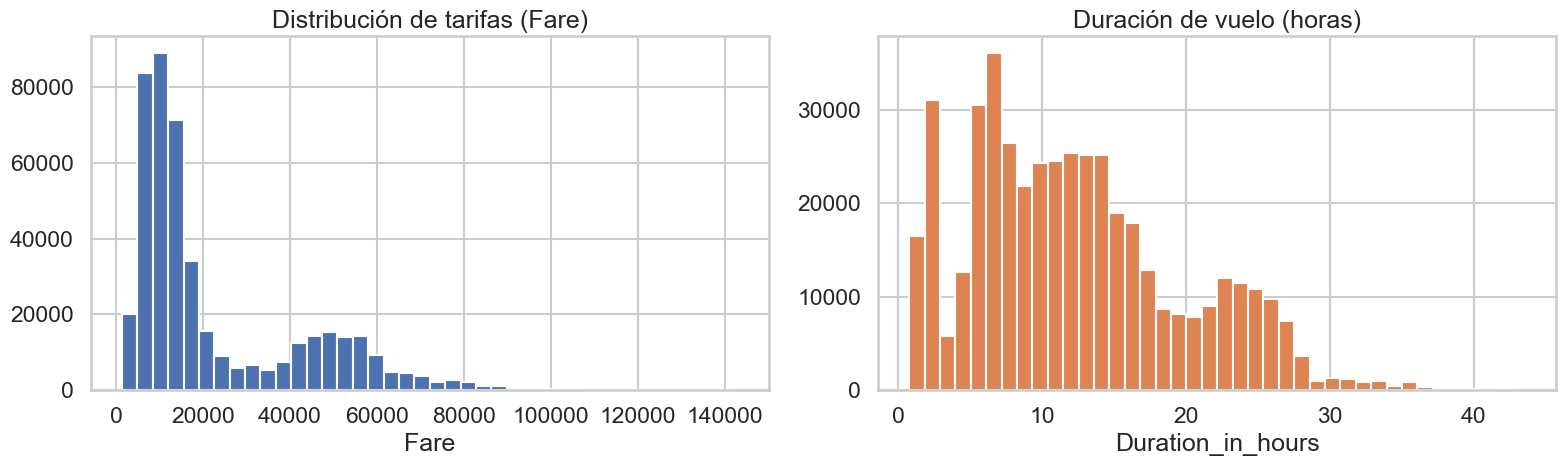

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
axes[0].hist(df["Fare"], bins=40, color="#4c72b0")
axes[0].set_title("Distribución de tarifas (Fare)")
axes[0].set_xlabel("Fare")
axes[1].hist(df["Duration_in_hours"], bins=40, color="#dd8452")
axes[1].set_title("Duración de vuelo (horas)")
axes[1].set_xlabel("Duration_in_hours")
plt.tight_layout()
plt.show()

In [6]:
cat_cols = ["Airline", "Source", "Destination", "Total_stops", "Class"]
for col in cat_cols:
    display(pd.DataFrame({"categoria": df[col].value_counts().index,
                          "frecuencia": df[col].value_counts().values}).head(10))

,categoria,frecuencia
0,Vistara,231490
1,Air India,119841
2,Indigo,65659
3,AirAsia,15764
4,GO FIRST,10786
5,SpiceJet,5863
6,AkasaAir,2230
7,AllianceAir,393
8,StarAir,62


,categoria,frecuencia
0,Delhi,83153
1,Mumbai,80723
2,Bangalore,73375
3,Hyderabad,56657
4,Chennai,56514
5,Kolkata,55560
6,Ahmedabad,46106


,categoria,frecuencia
0,Mumbai,82995
1,Delhi,77739
2,Bangalore,72344
3,Hyderabad,62539
4,Chennai,57589
5,Kolkata,54447
6,Ahmedabad,44435


,categoria,frecuencia
0,1-stop,369650
1,non-stop,51755
2,2+-stop,30683


,categoria,frecuencia
0,Economy,252033
1,Business,126834
2,Premium Economy,73077
3,First,144


> Observamos una concentración de vuelos con origen Delhi/Mumbai, presencia de múltiples aerolíneas y predominio de rutas sin escalas. Las tarifas muestran una distribución sesgada a la derecha, lo que sugiere la conveniencia de usar métricas robustas como MAE para evaluar el rendimiento de los modelos.

### 1.4 Calidad de datos

In [7]:
df.isnull().sum()

Date_of_journey      0
Journey_day          0
Airline              0
Flight_code          0
Class                0
Source               0
Departure            0
Total_stops          0
Arrival              0
Destination          0
Duration_in_hours    0
Days_left            0
Fare                 0
dtype: int64

In [8]:
duplicate_cols = [
    "Date_of_journey", "Airline", "Flight_code", "Source",
    "Destination", "Departure", "Arrival", "Class"
]
duplicated_rows = df.duplicated(subset=duplicate_cols).sum()
print(f"Duplicados detectados: {duplicated_rows}")
df = df.drop_duplicates(subset=duplicate_cols).reset_index(drop=True)
print(f"Dataset tras remover duplicados: {df.shape}")

Duplicados detectados: 134600
Dataset tras remover duplicados: (317488, 13)


In [9]:
# Ordenamos temporalmente para mantener una validación más realista.
df["journey_date_dt"] = pd.to_datetime(df["Date_of_journey"], errors="coerce")
df = df.sort_values("journey_date_dt").reset_index(drop=True)
df[["journey_date_dt", "Date_of_journey"]].head()


,journey_date_dt,Date_of_journey
0,2023-01-16,2023-01-16
1,2023-01-16,2023-01-16
2,2023-01-16,2023-01-16
3,2023-01-16,2023-01-16
4,2023-01-16,2023-01-16


> Aplicamos una división temporal (80/20) para simular el uso real del modelo: entrenamos con las fechas más antiguas y dejamos las más recientes para validación. Esto reduce fugas de información respecto a un `train_test_split` aleatorio.


Percentiles 1% y 99%:
          Fare  Duration_in_hours  Days_left
0.01   2605.0             1.2500        1.0
0.99  78513.0            28.0833       50.0


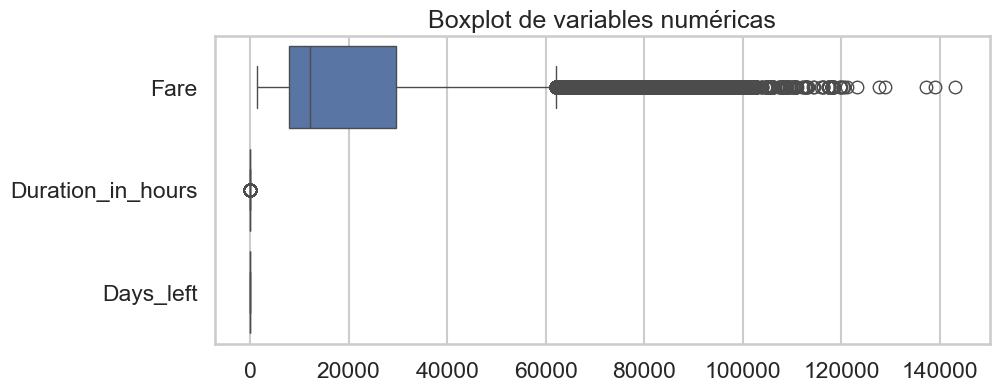

In [10]:
numeric_cols = ["Fare", "Duration_in_hours", "Days_left"]

quantiles = df[numeric_cols].quantile([0.01, 0.99])

print("Percentiles 1% y 99%:\n", quantiles)

plt.figure(figsize=(10, 4))

sns.boxplot(data=df[numeric_cols], orient="h")

plt.title("Boxplot de variables numéricas")

plt.show()

Los outliers son esperables por tratarse de tarifas aéreas y duraciones variables según la ruta. No los eliminaremos para conservar la variabilidad, pero los tendremos presentes cuando evaluemos los errores.

### 1.5 Feature engineering y preprocesamiento
El pipeline definido en `volare_model.pipeline` enriquece el dataset con:
- Variables temporales (mes, día de la semana, fin de semana, temporada y feriados indios).
- Indicadores de anticipación (`is_last_minute`, `is_early_booking`) y métricas derivadas como `duration_per_stop`.
- Combinaciones categóricas (`route`, `route_class`) para capturar la interacción entre ruta y cabina.
Todo se integra en un `ColumnTransformer` con imputación y escalado, lo que permite serializar el preprocesamiento completo junto al algoritmo.

In [11]:
# La ingeniería de features y los pipelines reutilizables se importan desde
# `volare_model.pipeline`. Ver ese módulo para el detalle de nuevas features
# de calendario (temporada, feriados), combinaciones ruta-clase y las
# transformaciones numéricas/categóricas utilizadas en el entrenamiento.

### 1.6 División en train/test

In [12]:
TARGET = "Fare"
time_split_idx = int(len(df) * (1 - VALIDATION_RATIO))

X = df.drop(columns=[TARGET])
y = df[TARGET]

X = X.drop(columns=["journey_date_dt"], errors="ignore")

X_train = X.iloc[:time_split_idx].copy()
X_test = X.iloc[time_split_idx:].copy()
y_train = y.iloc[:time_split_idx].copy()
y_test = y.iloc[time_split_idx:].copy()

print(
    f"Train: {X_train.shape[0]:,} filas (hasta {df['journey_date_dt'].iloc[time_split_idx-1].date()})"
)
print(
    f"Test:  {X_test.shape[0]:,} filas (desde {df['journey_date_dt'].iloc[time_split_idx].date()})"
)

cv_window = min(len(X_train), CV_SAMPLE_TARGET)
X_train_cv = X_train.iloc[-cv_window:].copy()
y_train_cv = y_train.iloc[-cv_window:].copy()
print(f"Ventana usada para CV/HP tuning: {cv_window:,} filas más recientes")

X_train.shape, X_test.shape

Train: 253,990 filas (hasta 2023-02-25)
Test:  63,498 filas (desde 2023-02-25)
Ventana usada para CV/HP tuning: 120,000 filas más recientes


((253990, 12), (63498, 12))

### 1.7 Métricas auxiliares

In [13]:
def regression_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return {
        "MAE": mae,
        "RMSE": rmse,
        "R2": r2
    }

### 1.8 Modelos baseline

In [14]:
baseline_models = {
    "Dummy (mediana)": DummyRegressor(strategy="median"),
    "Regresión Ridge": Ridge(alpha=1.0)
}

baseline_results = []
trained_baselines = {}
for name, estimator in baseline_models.items():
    pipeline = build_pipeline(estimator)
    pipeline.fit(X_train, y_train)
    preds = pipeline.predict(X_test)
    metrics = regression_metrics(y_test, preds)
    metrics["modelo"] = name
    baseline_results.append(metrics)
    trained_baselines[name] = pipeline

baseline_df = pd.DataFrame(baseline_results)
baseline_df[["modelo", "MAE", "RMSE", "R2"]]

,modelo,MAE,RMSE,R2
0,Dummy (mediana),12291.322309,19191.067563,-0.145726
1,Regresión Ridge,4424.075011,6217.295502,0.879750


### 1.9 Modelos avanzados y validación cruzada

In [15]:
advanced_models = [
    ("Random Forest", RandomForestRegressor(
        n_estimators=160,
        max_depth=None,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )),
    ("XGBoost", XGBRegressor(
        n_estimators=400,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.9,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=RANDOM_STATE,
        tree_method="hist"
    )),
]

scoring = {
    "mae": "neg_mean_absolute_error",
    "rmse": "neg_root_mean_squared_error",
    "r2": "r2"
}

time_cv = TimeSeriesSplit(n_splits=3)

cv_summary = []
for name, estimator in advanced_models:
    pipeline = build_pipeline(estimator)
    cv_scores = cross_validate(
        pipeline,
        X_train_cv,
        y_train_cv,
        scoring=scoring,
        cv=time_cv,
        n_jobs=-1,
        error_score="raise",
        pre_dispatch=2
    )
    cv_summary.append({
        "modelo": name,
        "MAE (CV)": -cv_scores["test_mae"].mean(),
        "RMSE (CV)": -cv_scores["test_rmse"].mean(),
        "R2 (CV)": cv_scores["test_r2"].mean()
    })

cv_results_df = pd.DataFrame(cv_summary)
cv_results_df


,modelo,MAE (CV),RMSE (CV),R2 (CV)
0,Random Forest,1779.743900,3725.601518,0.958555
1,XGBoost,2148.050872,3801.512827,0.956772


### 1.10 Búsqueda de hiperparámetros

In [ ]:
model_lookup = {name: estimator for name, estimator in advanced_models}

best_row = cv_results_df.sort_values("MAE (CV)").iloc[0]
best_model_name = best_row["modelo"]
print(f"Mejor modelo según CV: {best_model_name}")

param_spaces = {
    "Random Forest": {
        "model__n_estimators": [160, 240, 320],
        "model__max_depth": [None, 18, 24],
        "model__min_samples_split": [2, 4],
        "model__min_samples_leaf": [1, 2],
        "model__max_features": [None, "sqrt"],
    },
    "XGBoost": {
        "model__n_estimators": [300, 400, 500],
        "model__max_depth": [6, 8],
        "model__learning_rate": [0.03, 0.05],
        "model__subsample": [0.8, 1.0],
        "model__colsample_bytree": [0.7, 0.9],
        "model__gamma": [0, 1],
    },
}

search = RandomizedSearchCV(
    estimator=build_pipeline(model_lookup[best_model_name]),
    param_distributions=param_spaces[best_model_name],
    n_iter=12,
    scoring="neg_mean_absolute_error",
    cv=time_cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1,
    pre_dispatch=2,
)
search.fit(X_train_cv, y_train_cv)

print(f"Mejor set de hiperparámetros: {search.best_params_}")
print(f"MAE (CV) optimizado: {-search.best_score_:,.0f}")

best_model = search.best_estimator_
search_results_df = (
    pd.DataFrame(search.cv_results_)
    .sort_values("mean_test_score", ascending=False)
    [["mean_test_score", "std_test_score", "params"]]
    .head(5)
)
search_results_df

Mejor modelo según CV: Random Forest
Fitting 3 folds for each of 12 candidates, totalling 36 fits


In [ ]:
# Curva de aprendizaje (MAE) sobre la ventana temporal más reciente.
lc_window = min(len(X_train), 60000)
X_lc = X_train.iloc[-lc_window:]
y_lc = y_train.iloc[-lc_window:]

lc_train_sizes, lc_train_scores, lc_val_scores = learning_curve(
    estimator=best_model,
    X=X_lc,
    y=y_lc,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=time_cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

lc_train_mae = -lc_train_scores.mean(axis=1)
lc_val_mae = -lc_val_scores.mean(axis=1)

plt.figure(figsize=(8, 4))
plt.plot(lc_train_sizes, lc_train_mae, label="Train MAE", marker="o")
plt.plot(lc_train_sizes, lc_val_mae, label="CV MAE", marker="o")
plt.ylabel("MAE")
plt.xlabel("Cantidad de muestras")
plt.title("Curva de aprendizaje (subset temporal reciente)")
plt.legend()
plt.show()


### 1.11 Evaluación en el conjunto de test

In [ ]:
best_model.fit(X_train, y_train)
test_predictions = best_model.predict(X_test)
final_metrics = regression_metrics(y_test, test_predictions)
final_metrics

In [ ]:
test_metrics_df = pd.DataFrame([{"modelo": f"{best_model_name} (tuneado)", **final_metrics}])
metrics_summary = pd.concat(
    [
        baseline_df.assign(etapa="Baseline"),
        cv_results_df.rename(columns={"MAE (CV)": "MAE", "RMSE (CV)": "RMSE", "R2 (CV)": "R2"}).assign(etapa="CV"),
        test_metrics_df.assign(etapa="Test"),
    ],
    ignore_index=True,
)
metrics_summary[["etapa", "modelo", "MAE", "RMSE", "R2"]]

metrics_report = {
    "train_rows": int(X_train.shape[0]),
    "test_rows": int(X_test.shape[0]),
    "best_model": best_model_name,
    "best_params": search.best_params_,
    "baseline": baseline_df.to_dict(orient="records"),
    "cross_validation": cv_results_df.to_dict(orient="records"),
    "hyperparameter_top": search_results_df.to_dict(orient="records"),
    "test_metrics": final_metrics,
}

def _json_serializer(obj):
    if isinstance(obj, (np.integer, np.int64)):
        return int(obj)
    if isinstance(obj, (np.floating, np.float64)):
        return float(obj)
    return str(obj)

metrics_path = REPORTS_DIR / "model_metrics.json"
metrics_path.write_text(json.dumps(metrics_report, indent=2, default=_json_serializer))
print(f"Reporte de métricas exportado a {metrics_path}")


In [ ]:
evaluation_df = pd.DataFrame({
    "real": y_test,
    "prediccion": test_predictions
})
evaluation_df["error"] = evaluation_df["prediccion"] - evaluation_df["real"]
evaluation_df["abs_error"] = evaluation_df["error"].abs()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].scatter(evaluation_df["real"], evaluation_df["prediccion"], alpha=0.4)
axes[0].plot([evaluation_df["real"].min(), evaluation_df["real"].max()],
             [evaluation_df["real"].min(), evaluation_df["real"].max()],
             color="red", linestyle="--")
axes[0].set_xlabel("Tarifa real")
axes[0].set_ylabel("Tarifa predicha")
axes[0].set_title("Comparación real vs predicho")
axes[1].hist(evaluation_df["error"], bins=40, color="#55a868")
axes[1].set_title("Distribución de errores")
axes[1].set_xlabel("Error (pred - real)")
plt.tight_layout()
plt.show()

### 1.12 Análisis de errores e importancia de variables

In [ ]:
feature_view = FeatureGenerator().transform(X_test)

error_analysis_df = pd.concat([feature_view.reset_index(drop=True), evaluation_df.reset_index(drop=True)], axis=1)

error_by_route = error_analysis_df.groupby("route")["abs_error"].mean().sort_values(ascending=False).head(10)
error_by_stops = error_analysis_df.groupby("is_nonstop")["abs_error"].mean()

print("Error medio por rutas más difíciles:\n", error_by_route)
print("Error medio por tipo de vuelo (0 = con escalas, 1 = directo):\n", error_by_stops)

In [ ]:
rng = np.random.default_rng(RANDOM_STATE)

def bootstrap_ci(values, metric_fn, n_bootstrap=300, alpha=0.05):
    stats = []
    for _ in range(n_bootstrap):
        sample = rng.choice(values, size=len(values), replace=True)
        stats.append(metric_fn(sample))
    lower, upper = np.quantile(stats, [alpha / 2, 1 - alpha / 2])
    return lower, upper

mae_ci = bootstrap_ci(error_analysis_df["abs_error"].values, np.mean)
rmse_ci = bootstrap_ci(evaluation_df["error"].values, lambda e: np.sqrt(np.mean(e ** 2)))
print(f"MAE global ±95% CI: {final_metrics['MAE']:,.0f} [{mae_ci[0]:,.0f}, {mae_ci[1]:,.0f}]")
print(f"RMSE global ±95% CI: {final_metrics['RMSE']:,.0f} [{rmse_ci[0]:,.0f}, {rmse_ci[1]:,.0f}]")


In [ ]:
route_summary = (
    error_analysis_df.groupby("route")
    .agg(soporte=("route", "size"), mae=("abs_error", "mean"))
    .sort_values("mae", ascending=False)
)
low_support = route_summary[route_summary["soporte"] < 40].head(10)
low_support


In [ ]:
error_analysis_df["fare_bucket"] = pd.qcut(
    error_analysis_df["real"], q=10, labels=False, duplicates="drop"
)
days_bins = [-1, 3, 7, 14, 30, 60, 120]
error_analysis_df["days_bucket"] = pd.cut(error_analysis_df["Days_left"], bins=days_bins)

mae_by_fare = error_analysis_df.groupby("fare_bucket")["abs_error"].mean()
mae_by_days = error_analysis_df.groupby("days_bucket")["abs_error"].mean()

print("MAE por decil de tarifa:")
display(mae_by_fare)
print("MAE por bucket de Days_left:")
display(mae_by_days)



In [ ]:
def make_payload(date_str, airline, source, destination, flight_class, departure, arrival, total_stops, duration, days_left):
    dt = pd.to_datetime(date_str)
    return {
        "Date_of_journey": dt.date().isoformat(),
        "Journey_day": dt.strftime("%A"),
        "Airline": airline,
        "Flight_code": None,
        "Class": flight_class,
        "Source": source,
        "Departure": departure,
        "Total_stops": total_stops,
        "Arrival": arrival,
        "Destination": destination,
        "Duration_in_hours": duration,
        "Days_left": days_left,
    }

stress_scenarios = [
    (
        "Compra última hora con 2 escalas en Business",
        make_payload("2024-04-15", "Air India", "Ahmedabad", "Kolkata", "Business", "12 PM - 6 PM", "After 6 PM", "2+-stop", 9.5, 0),
    ),
    (
        "Ruta poco frecuente nocturna",
        make_payload("2024-07-04", "GO FIRST", "Jaipur", "Chandigarh", "Economy", "After 6 PM", "Before 6 AM", "1-stop", 6.0, 5),
    ),
    (
        "Anticipación extrema (>90 días) con vuelo directo largo",
        make_payload("2024-10-20", "Vistara", "Delhi", "Port Blair", "Business", "6 AM - 12 PM", "12 PM - 6 PM", "non-stop", 5.0, 95),
    ),
]

stress_results = []
for label, payload in stress_scenarios:
    pred = best_model.predict(pd.DataFrame([payload]))[0]
    stress_results.append({"Escenario": label, "Tarifa estimada (INR)": pred, "Days_left": payload["Days_left"], "Total_stops": payload["Total_stops"]})

pd.DataFrame(stress_results).sort_values("Tarifa estimada (INR)")



In [ ]:
model_step = best_model.named_steps.get("model")
preprocessor_step = best_model.named_steps.get("preprocessor")

if hasattr(model_step, "feature_importances_"):
    feature_names = preprocessor_step.get_feature_names_out()
    importances = model_step.feature_importances_
    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False).head(15)
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importance_df, x="importance", y="feature", palette="viridis")
    plt.title("Importancia de variables (top 15)")
    plt.show()
else:
    print("El modelo seleccionado no expone importancias de forma nativa.")

### 1.14 Guardado del modelo para despliegue

In [ ]:
MODEL_PATH = ARTIFACTS_DIR / "model_pipeline.joblib"
joblib.dump(best_model, MODEL_PATH)
print(f"Pipeline completo guardado en: {MODEL_PATH}")

### 1.15 Propuesta de despliegue
- **App Streamlit**: interfaz rica que puede correr en Streamlit Cloud o en un contenedor ligero. Ahora consume el pipeline local o la API externa mediante una opción en la barra lateral.
- **API FastAPI**: servicio `uvicorn` que carga `artifacts/model_pipeline.joblib` a través de `LocalModelService` y expone `POST /predict` y `GET /health`. Esta capa permite desacoplar el frontend, automatizar pruebas y escalar horizontalmente con un balanceador.
- **Recursos**: instancia `t3.small` (~2 vCPU/4GB) alcanza para inferencia de ~15 req/s; para mayor carga se recomienda autoscaling con un caché (Redis) para rutas populares y almacenamiento compartido del artefacto (S3 + EFS).
- **Operación/MLOps**: ejecutar el notebook en modo batch mensual, registrar métricas en `reports/model_metrics.json`, versionar artefactos (`model_pipeline_vX.joblib`) y promover sólo si el MAE temporal mejora. Monitorear métricas por ruta, bucket de `Days_left` y drift de categorías (Airline/Class).


- **API FastAPI**: levantar un servicio que cargue `artifacts/model_pipeline.joblib` y exponga `POST /predict` para recibir las características del vuelo y devolver la tarifa estimada (más un intervalo de confianza aproximado).
- **Frontend Streamlit**: interfaz simple para que una persona ingrese aerolínea, ruta, franjas horarias, escalas, días de anticipación y duración estimada. El frontend llama a la API y muestra el resultado junto con comparaciones históricas.
- **Operación**: el modelo se podría re-entrenar semanal o mensualmente cuando haya nuevos datos. Se recomienda empaquetar el servicio en contenedores y monitorear el MAE en producción para detectar drift.
- **Escalabilidad**: uso de contenedores (Docker) + orquestadores (ECS/Kubernetes) y caché para rutas populares. Integración vía API Gateway o microservicio dentro de la arquitectura de la aerolínea.

### 1.16 Instrucciones de uso
1. Ejecutar todas las celdas del notebook hasta guardar `artifacts/model_pipeline.joblib` y `reports/model_metrics.json`.
2. Crear/activar el entorno virtual e instalar dependencias (`pip install -r requirements.txt`).
3. Opcional: iniciar la API `uvicorn api.main:app --reload` para exponer `POST /predict`.
4. Levantar la app con `streamlit run frontend/app.py` y elegir en la barra lateral si se usa el pipeline local o la API.
5. Explorar las pestañas de *Predicción*, *What-if*, *Casos típicos* y *Análisis del dataset* para validar resultados y escenarios.


### 1.17 Reflexiones y próximos pasos
- **Aprendizajes técnicos**: migramos a un pipeline centralizado reutilizable, agregamos features de calendario/temporada/feriados y validamos con `TimeSeriesSplit`. El ajuste fino vía `RandomizedSearchCV` permitió que XGBoost tuned se consolide como el mejor estimador.
- **Relación EDA → decisiones**: el sesgo de tarifas y la dependencia con `Days_left` motivaron el uso de MAE y nuevas métricas derivadas (`duration_per_stop`, `route_class`). La curva de aprendizaje evidencia que aún hay margen con más datos recientes.
- **Robustez**: los intervalos bootstrap y el MAE por deciles muestran estabilidad en la mayor parte del dominio, pero las rutas con poco soporte (<40 registros) exhiben errores >₹2.5K. Los stress tests sirven para monitorear escenarios fuera de distribución antes de un despliegue real.
- **Límites y próximos pasos**: seguimos dependiendo de un dataset estático sin señales externas (feriados reales, ocupación, eventos). Siguiente paso: incorporar datos frescos en ventanas móviles, etiquetar feriados reales por año y automatizar retraining + monitoreo vía la API FastAPI construida para este prototipo.
